In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

%matplotlib inline

## Introduction

I am a chess player. I used to play in my youth a lot but then lost contact to the game due to lack of playing partners. I couple of years ago I discovered [Lichess.org](https://lichess.org) and got back into playing. This
re-boosted my playing level and this I thoght I use their free Lichess data for this data science project on chess openings.

[Lichess.org](https://lichess.org) is a free online chess server that provides an extensive data set on all games that have been played between Jan 2013 until today at the [Lichess.org open database](https://database.lichess.org). At the time of wrtiing, this data comprises almost 1.5TB. The data is split into files per month that stored as compressed PGN. PGN data contain metadata and the moves plus timing and scoring information and is tailored for chess engines to replay and analyze games. In our example, we only need the metadata.

I picked one rather small file with 121,332 games,extracted the metadata, applied some cleansing, stripped the game moves and wrote the data as csv. The resulting data file is much smaller and loads much faster. I wh=rote a litte preprocessor for this task, so if you want to analyze other PGN files you need to run the `pgn2csv.py` preprocessor located in this directory
``` sh
$ python3 ./pgn2csv.py <your pgn input file with games data> <your csv output file>
```

In [20]:
df = pd.read_csv('lichess_db_standard_rated.csv.gz')
df

,eco,opening,opening_base,winner,timestamp,white_elo,black_elo,time_control,termination
0,C00,French Defense: Normal Variation,French Defense,White,1356994863,1639.0,1403.0,600+8,Normal
1,D04,"Queen's Pawn Game: Colle System, Anti-Colle",Queen's Pawn Game,White,1356995052,1654.0,1919.0,480+2,Normal
2,C50,Four Knights Game: Italian Variation,Four Knights Game,White,1356994995,1643.0,1747.0,420+17,Normal
3,B12,Caro-Kann Defense: Goldman Variation,Caro-Kann Defense,Black,1356995097,1824.0,1973.0,60+1,Normal
4,C00,French Defense: La Bourdonnais Variation,French Defense,Black,1356994957,1765.0,1815.0,60+1,Normal
...,...,...,...,...,...,...,...,...,...
121327,E80,King's Indian Defense: Saemisch Variation,King's Indian Defense,Black,1359673148,1854.0,1937.0,600+10,Normal
121328,B01,Scandinavian Defense,Scandinavian Defense,Black,1359673153,1500.0,1266.0,720+0,Time forfeit
121329,B01,Scandinavian Defense: Mieses-Kotroc Variation,Scandinavian Defense,Black,1359673167,1431.0,1523.0,960+6,Normal
121330,B00,Barnes Defense,Barnes Defense,White,1359673181,1693.0,1479.0,180+1,Normal


The preprocessor adds an `opening_base` column that generalizes the paritular opening to the root opening system. Chess openings are classified in a tree-like fashion. The tree starts at the opening system (e.g., Queen's Pawn Game) and then names the variants and sub-variants (e.g., Queen's Pawn Game: Colle System, Anti-Colle). There are complex openings with lots of variants for which a lot of theoretical research has been done, and less complex openings. In order to get reasonably sized classes, I decided to map the individual opening to its opening system which is stored in a separate column.

In total, we get 9 columns:
- **eco**: the Eco code of the opening
- **opening**: the opening name
- **opening_base**: the opening system (see above)
- **winner**: the winner of the game as one of ['White', 'Black', 'Draw'].
- **timestamp**: when the game was played
- **time_control**: Time limit plus seconds added per move
- **termination**: Reason for terminating the game as one of ['Normal', Time forfait'].

The PGN data also contains the Lichess user names of the players. The preprocessor suppresses this information for privacy reasons.

## Business Questions

Our data contains the winner of each game (White, Draw, Black), the playing strength of both opponenents (as ELO nummers, the ECO code and the name of the opening. In this demo, we will analyze three questions. The firsat question is an obvious choice when looking at the data:

**1. What are the most frequently used opening systems?**

The choice of the openening is known to depend on the player's level of skill. Less experienced players often use rare and sharp openings in order to surprise the opponent and trick him into a blunder. More experienced players tend to use complex opening systems and choose theit preferred well-studied variant. This leads to the next question:

**2. Do we see a change in the most frequently used opening systems if we break the data by skill level?**

And finally, it may be even more interesting to see how often a particular chosen opening led to white or black winning the game, again per skill level. So, the last question addresses here is

**3. What are the most suceefull opening systems for White and Black per skill level?**

With these questions it is clear that we do not need the timestamp, time_control and termination columns although they might be intersting for other purposes.

## Data Preparation


#### Missing Values

Lichess also alllows unregistered players to play games. In this, case there is no ELO number indicating the player's strength. Let's see what's the proporation if such missng data is:

In [21]:
df.isnull().sum()

eco               0
opening           0
opening_base      0
winner            0
timestamp         0
white_elo        78
black_elo       140
time_control      0
termination       0
dtype: int64

With only 78 non-existing ELOs for white and 140 for black in a data corpus of more than 120,000 games, it is save to replace the missing values with the average of the ELO numbers per column.

In [22]:
for col in ['white_elo', 'black_elo']: 
    df[col].fillna(df[col].mean(), inplace=True)

#### Drop Columns

It does not matter at what time the games were played. Delete the `timestamp` column.

In [23]:
df.drop(['timestamp'], axis = 1, inplace=True)

## Question 1: What are the most frequently used opening systems?

We can answer this question immediately by counting the unique value of `opening_base` over the entire data frame.

In [24]:
# Get the frequently used openings
openings = df.opening_base.value_counts()
openings.head(10)

opening_base
Sicilian Defense        11685
French Defense           7508
Queen's Pawn Game        6489
King's Pawn Game         5274
Scandinavian Defense     5207
Van't Kruijs Opening     3995
English Opening          3942
Italian Game             3923
Ruy Lopez                3458
Caro-Kann Defense        3357
Name: count, dtype: int64

A utility function for plotting the bar chart,

In [84]:
def pie_chart(df, title, savefig=False):
    """
    Plots a bar chart showing the proportions
    of the passed series of unjqie values.
    """
    
    (df.nlargest(10)/df.sum()).plot(kind='pie', autopct='%1.1f%%', ylabel='' , legend=None);
    plt.title(title);
    if savefig:
        plt.savefig('./images/' + title.replace(" ", "_") +'.jpg')
    plt.show();
    
help(pie_chart)

Help on function pie_chart in module __main__:

pie_chart(df, title, savefig=False)
    Plots a bar chart showing the proportions
    of the passed series of unjqie values.



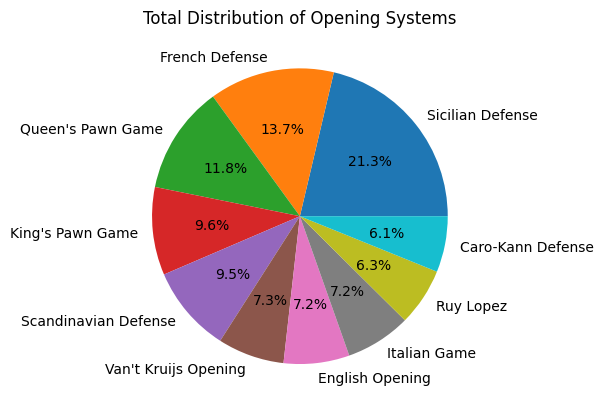

In [81]:
#plot
pie_chart(openings, 'Total Distribution of Opening Systems', savefig=True)

## Question 2: What are the most frequently used opening systems per skill level?

We will address this question only for White but with repspect to all skill levels. We define the cohorts of players of similar strenght via filters over the ELO number that can be applied to the main data frame to get to the cohort subset. I chose four different cohorts

- **beginner game** average elo &le; 1200
- **intermediate game** 1200 &gt; average elo &le; 1600 
- **advanced game** 1600 &gt; average eelo &le; 2000 
- **expert game** average elo &gt; 2000 

<Axes: >

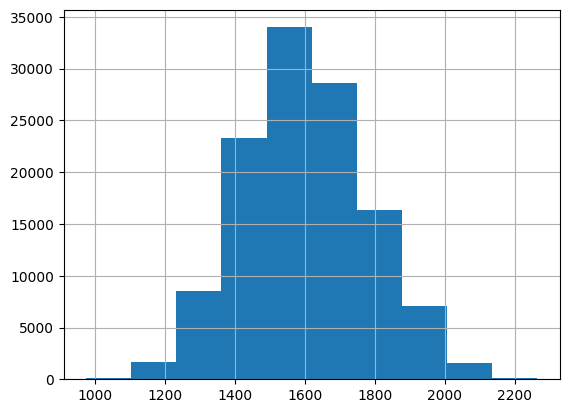

In [27]:
df[['white_elo', 'black_elo']].mean(axis=1).hist()

In [28]:
# cohorts for games
beginner = (df[['white_elo', 'black_elo']].mean(axis=1) <= 1200)
intermediate = (df[['white_elo', 'black_elo']].mean(axis=1) > 1200) & (df[['white_elo', 'black_elo']].mean(axis=1) <= 1600)
advanced = ((df[['white_elo', 'black_elo']].mean(axis=1) > 1600) & (df[['white_elo', 'black_elo']].mean(axis=1) <= 2000))
expert = (df[['white_elo', 'black_elo']].mean(axis=1) > 2000)

In [29]:
beginners = df[beginner].opening_base.value_counts()
beginners.nlargest(10)

opening_base
Van't Kruijs Opening    116
King's Pawn Game         81
Queen's Pawn Game        59
French Defense           54
Scandinavian Defense     52
Zukertort Opening        34
Sicilian Defense         31
Alekhine Defense         29
Kadas Opening            27
Hungarian Opening        25
Name: count, dtype: int64

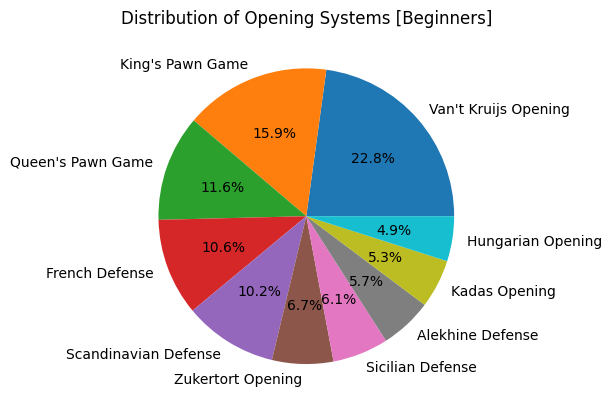

In [30]:
# using above utility function
pie_chart(beginners, 'Distribution of Opening Systems [Beginners]')

In [31]:
intermediates = df[intermediate].opening_base.value_counts()
intermediates.nlargest(10)

opening_base
Sicilian Defense        4561
King's Pawn Game        3966
Queen's Pawn Game       3383
French Defense          3354
Scandinavian Defense    2992
Van't Kruijs Opening    2615
Italian Game            2139
Bishop's Opening        2020
Ruy Lopez               1846
English Opening         1718
Name: count, dtype: int64

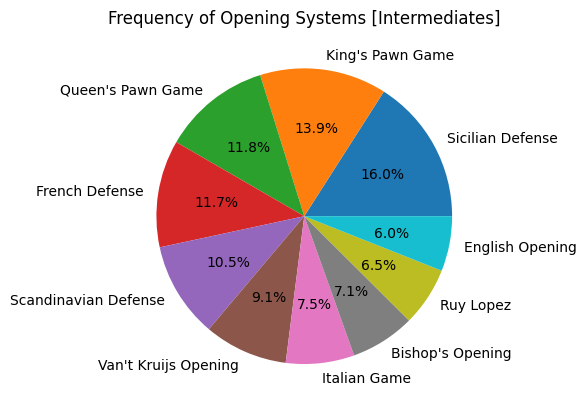

In [32]:
pie_chart(intermediates, 'Frequency of Opening Systems [Intermediates]')

In [33]:
advanced = df[advanced].opening_base.value_counts()
advanced.nlargest(10)

opening_base
Sicilian Defense        6778
French Defense          3958
Queen's Pawn Game       2977
Caro-Kann Defense       2174
Scandinavian Defense    2131
English Opening         2107
Italian Game            1744
Owen Defense            1681
Hungarian Opening       1597
Ruy Lopez               1562
Name: count, dtype: int64

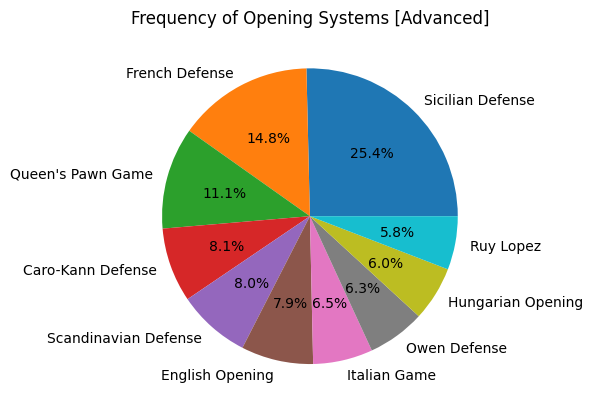

In [34]:
pie_chart(advanced, 'Frequency of Opening Systems [Advanced]')

In [35]:
experts = df[expert].opening_base.value_counts()
experts.nlargest(10)

opening_base
Sicilian Defense           315
French Defense             142
English Opening             94
Caro-Kann Defense           82
Queen's Gambit Declined     78
Queen's Pawn Game           70
Owen Defense                52
Modern Defense              45
St. George Defense          36
Zukertort Opening           35
Name: count, dtype: int64

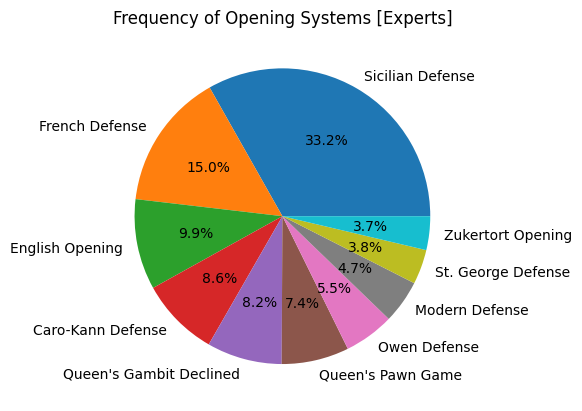

In [57]:
pie_chart(experts, 'Frequency of Opening Systems [Experts]')

In [83]:
def four_pie_chart(df1, df1_title, df2, df2_title, df3, df3_title, df4, df4_title, title, savefig = False):
    """
    Plots a box of four pie charts showing the proportions
    of the passed series of unique values.
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(13, 10))
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
 
    (df1.nlargest(10)/df1.sum()).plot(ax=axes[0,0], kind='pie', autopct='%1.1f%%', ylabel='', title=df1_title, legend=None);
    (df2.nlargest(10)/df2.sum()).plot(ax=axes[0,1], kind='pie', autopct='%1.1f%%', ylabel='', title=df2_title, legend=None);
    (df3.nlargest(10)/df3.sum()).plot(ax=axes[1,0], kind='pie', autopct='%1.1f%%', ylabel='', title=df3_title, legend=None);
    (df4.nlargest(10)/df4.sum()).plot(ax=axes[1,1], kind='pie', autopct='%1.1f%%', ylabel='', title=df4_title, legend=None);

    plt.suptitle(title);
    if savefig:
        plt.savefig('./images/' + title.replace(" ", "_") +'.pdf')
    plt.show()
    
help(four_pie_chart)

Help on function four_pie_chart in module __main__:

four_pie_chart(df1, df1_title, df2, df2_title, df3, df3_title, df4, df4_title, title, savefig=False)
    Plots a box of four pie charts showing the proportions
    of the passed series of unique values.



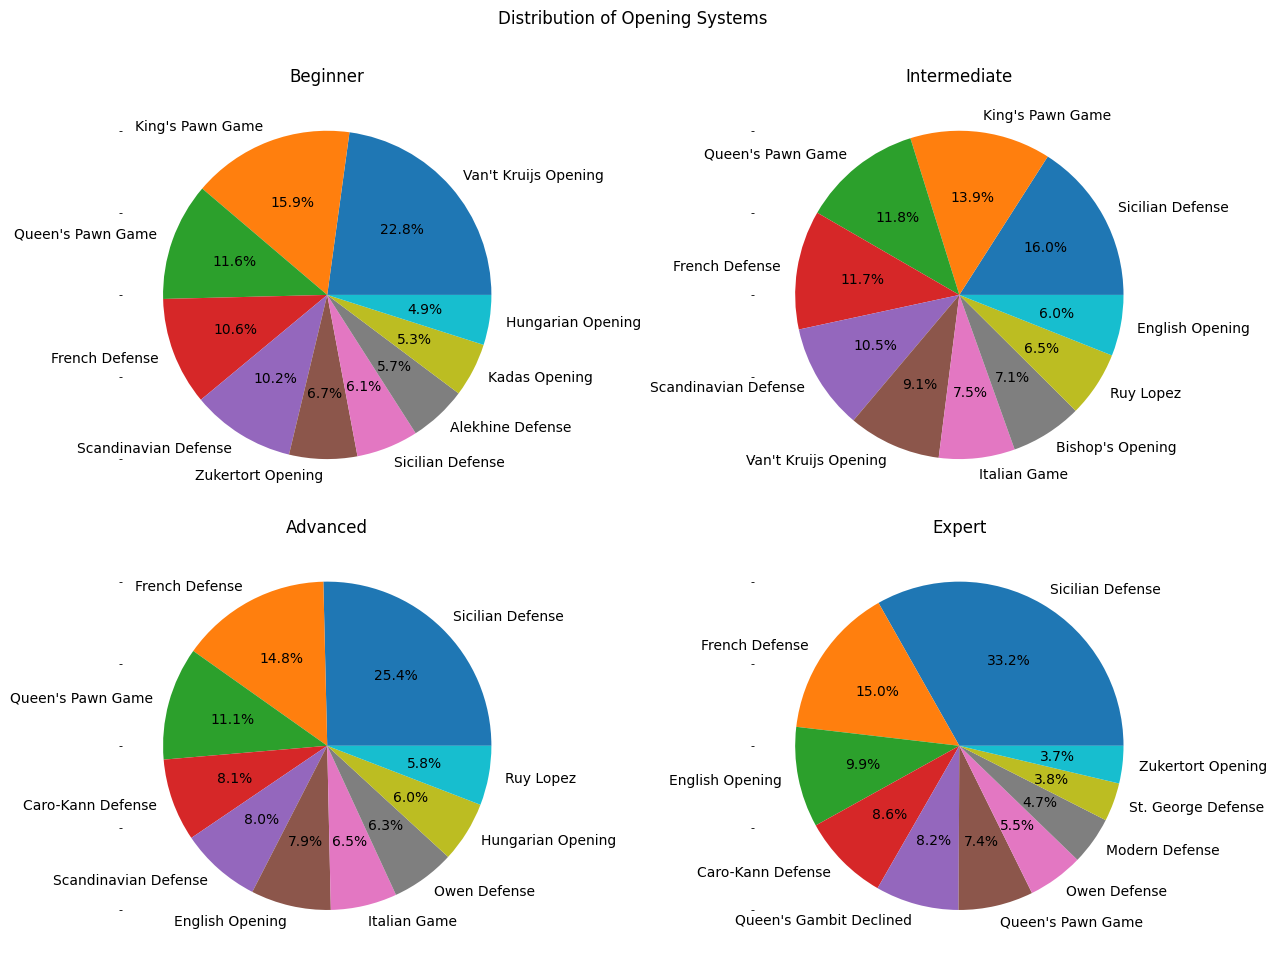

In [79]:
four_pie_chart(beginners, 'Beginner',
               intermediates, 'Intermediate',
               advanced, 'Advanced',
               experts, 'Expert',
               'Distribution of Opening Systems',
               savefig=True)

## Question 3: What are the most sucessfull opening systems for White and Black per skill level?

In [39]:
# cohorts for White
beginner_white = (df.white_elo <= 1200)
intermediate_white = (df.white_elo>1200) & (df.white_elo<=1600)
advanced_white = (df.white_elo>1600) & (df.white_elo<=2000)
expert_white = (df.white_elo > 2000)

# cohorts for Black
beginner_black = (df.black_elo <= 1200)
intermediate_black = (df.black_elo>1200) & (df.black_elo<=1600)
advanced_black = (df.black_elo>1600) & (df.black_elo<=2000)
expert_black = (df.black_elo > 2000)

For this question we have to project  the cohort's games onto the desired result (black win, white win), count the unique values for this result and extract the 10 largest values.

The following two functions help fetch the results and plot them.

In [40]:
def game_stats(df, result):
    """
    Retuns a series containing numbers of won games for a given result
    (white wins, black wins) grouped by opening_base.
    """
    return df[df.winner==result].groupby(['opening_base']).winner.value_counts()

help(game_stats)

Help on function game_stats in module __main__:

game_stats(df, result)
    Retuns a series containing numbers of won games for a given result
    (white wins, black wins) grouped by opening_base.



In [82]:
def two_pie_chart(dfw, dfw_title, dfb, dfb_title, title):
    """
    Plots two the pie charts top-10 series produced by
    game_stats next to each other. Used for Black/White comprison.
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,7))
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
        
    (dfw.nlargest(10)/dfw.sum()).plot(ax = axes[0], kind='pie', autopct='%1.1f%%', title=dfw_title, ylabel='');      
    (dfb.nlargest(10)/dfb.sum()).plot(ax = axes[1], kind='pie', autopct='%1.1f%%', title=dfb_title, ylabel='');
   
    plt.suptitle(title);
    plt.savefig('./images/' + title.replace(" ", "_") +'.pdf')
    plt.show();
        
help(two_pie_chart)

Help on function two_pie_chart in module __main__:

two_pie_chart(dfw, dfw_title, dfb, dfb_title, title)
    Plots two the pie charts top-10 series produced by
    game_stats next to each other. Used for Black/White comprison.



In [70]:
beginner_stats_white = game_stats(df[beginner_white], "White")
beginner_stats_black = game_stats(df[beginner_black], "Black")
beginner_stats_white.nlargest(10), beginner_stats_black.nlargest(10)

(opening_base          winner
 Van't Kruijs Opening  White     79
 King's Pawn Game      White     63
 Queen's Pawn Game     White     45
 French Defense        White     40
 Sicilian Defense      White     35
 Scandinavian Defense  White     29
 Zukertort Opening     White     28
 Scotch Game           White     20
 Alekhine Defense      White     19
 Horwitz Defense       White     14
 Name: count, dtype: int64,
 opening_base          winner
 Van't Kruijs Opening  Black     73
 King's Pawn Game      Black     62
 Scandinavian Defense  Black     49
 French Defense        Black     45
 English Opening       Black     28
 Queen's Pawn Game     Black     27
 Sicilian Defense      Black     23
 Alekhine Defense      Black     20
 Nimzowitsch Defense   Black     19
 Zukertort Opening     Black     18
 Name: count, dtype: int64)

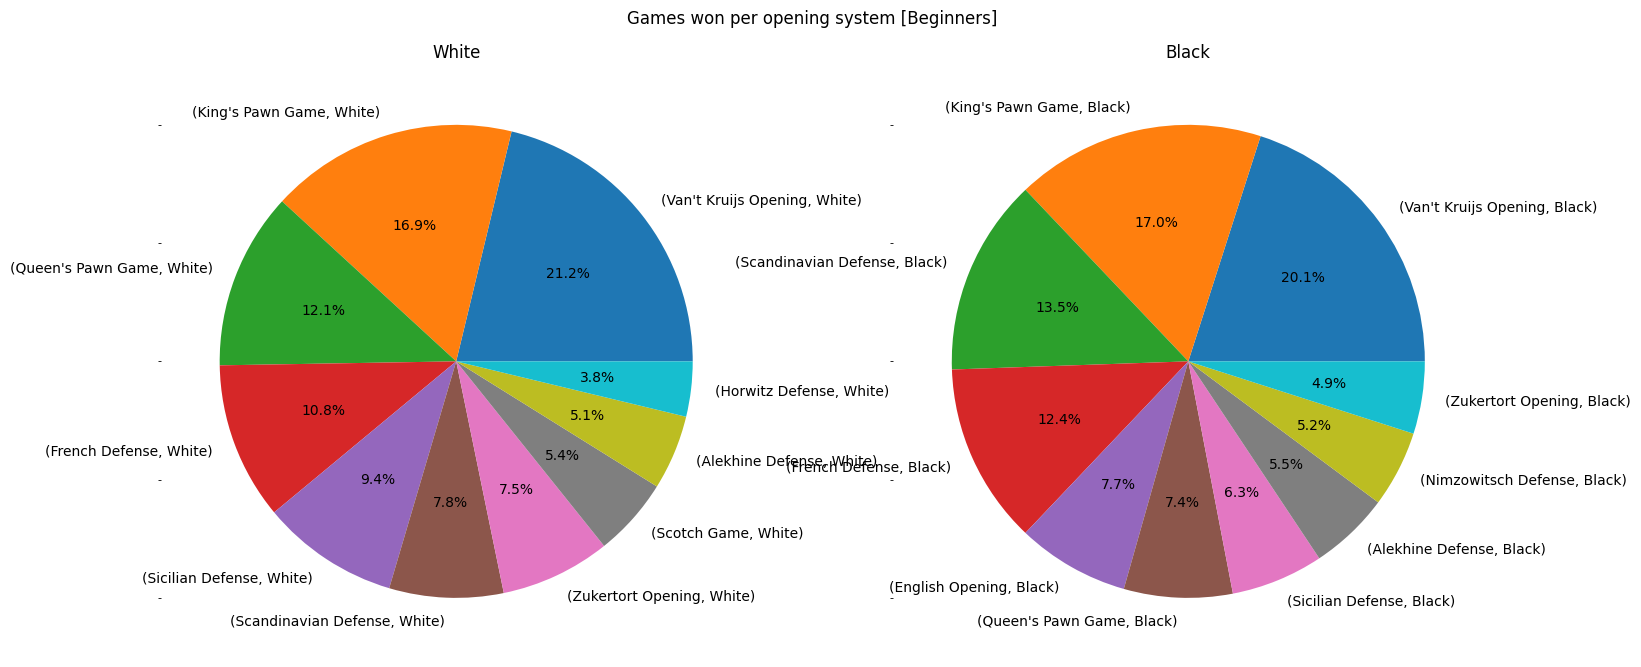

In [71]:
two_pie_chart(beginner_stats_white, 'White', beginner_stats_black, 'Black', 'Games won per opening system [Beginners]')

In [72]:
inter_stats_white = game_stats(df[intermediate_white], "White")
inter_stats_black = game_stats(df[intermediate_black], "Black")
inter_stats_white.nlargest(10), inter_stats_black.nlargest(10)

(opening_base          winner
 Sicilian Defense      White     1883
 King's Pawn Game      White     1711
 French Defense        White     1456
 Queen's Pawn Game     White     1402
 Scandinavian Defense  White     1398
 Van't Kruijs Opening  White     1043
 Italian Game          White      915
 Bishop's Opening      White      911
 Ruy Lopez             White      817
 English Opening       White      734
 Name: count, dtype: int64,
 opening_base          winner
 Sicilian Defense      Black     1810
 King's Pawn Game      Black     1563
 French Defense        Black     1295
 Queen's Pawn Game     Black     1257
 Van't Kruijs Opening  Black     1178
 Scandinavian Defense  Black     1012
 Italian Game          Black      803
 Ruy Lopez             Black      748
 Owen Defense          Black      737
 Bishop's Opening      Black      687
 Name: count, dtype: int64)

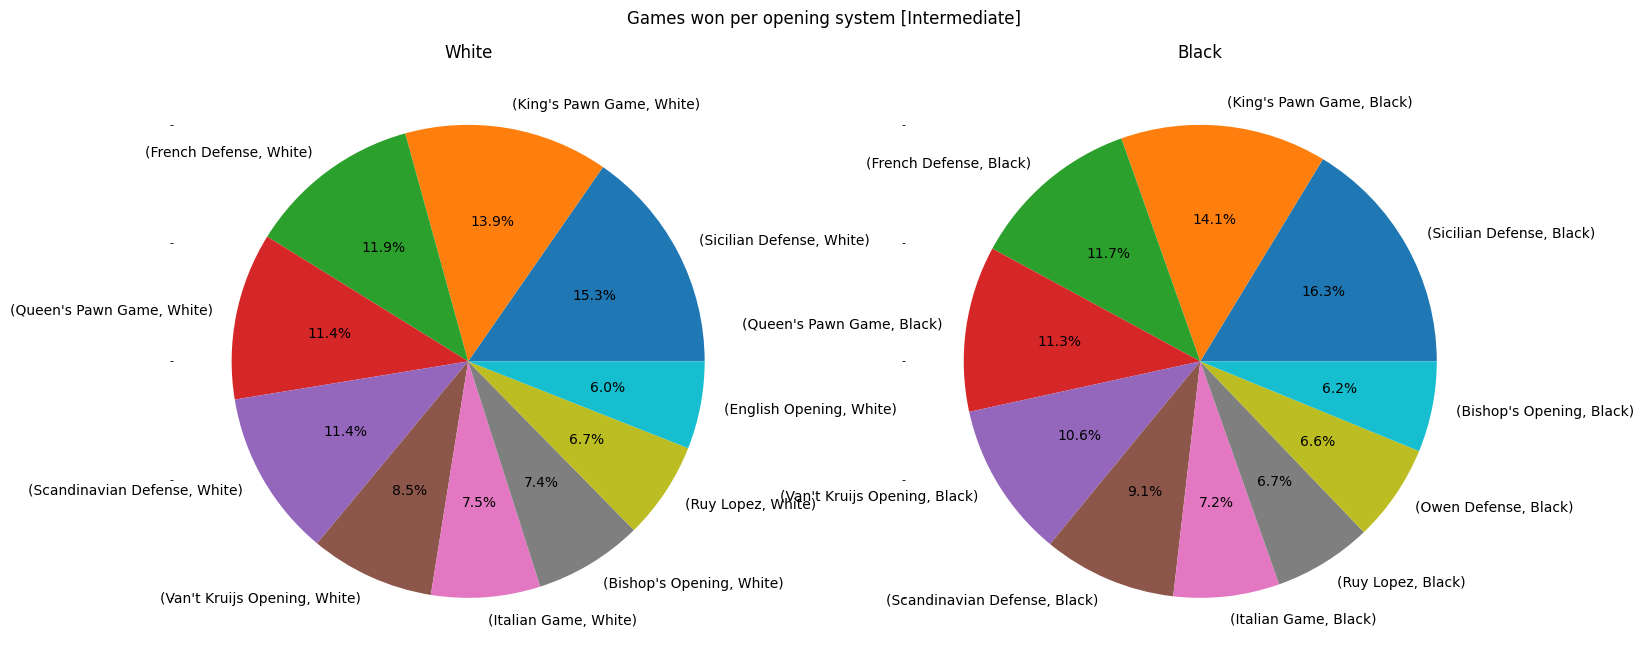

In [78]:
two_pie_chart(inter_stats_white, 'White', inter_stats_black, 'Black', 'Games won per opening system [Intermediate]')

In [74]:
advanced_stats_white = game_stats(df[advanced_white], "White")
advanced_stats_black = game_stats(df[advanced_black], "Black")
advanced_stats_white.nlargest(10), advanced_stats_black.nlargest(10)

(opening_base          winner
 Sicilian Defense      White     3123
 French Defense        White     1969
 Queen's Pawn Game     White     1839
 Scandinavian Defense  White     1337
 English Opening       White     1168
 Italian Game          White     1070
 Caro-Kann Defense     White     1010
 Owen Defense          White      960
 Hungarian Opening     White      948
 Ruy Lopez             White      915
 Name: count, dtype: int64,
 opening_base          winner
 Sicilian Defense      Black     3665
 French Defense        Black     2064
 Queen's Pawn Game     Black     1408
 Scandinavian Defense  Black     1111
 Caro-Kann Defense     Black     1027
 English Opening       Black      976
 Italian Game          Black      880
 Van't Kruijs Opening  Black      865
 King's Pawn Game      Black      841
 Ruy Lopez             Black      783
 Name: count, dtype: int64)

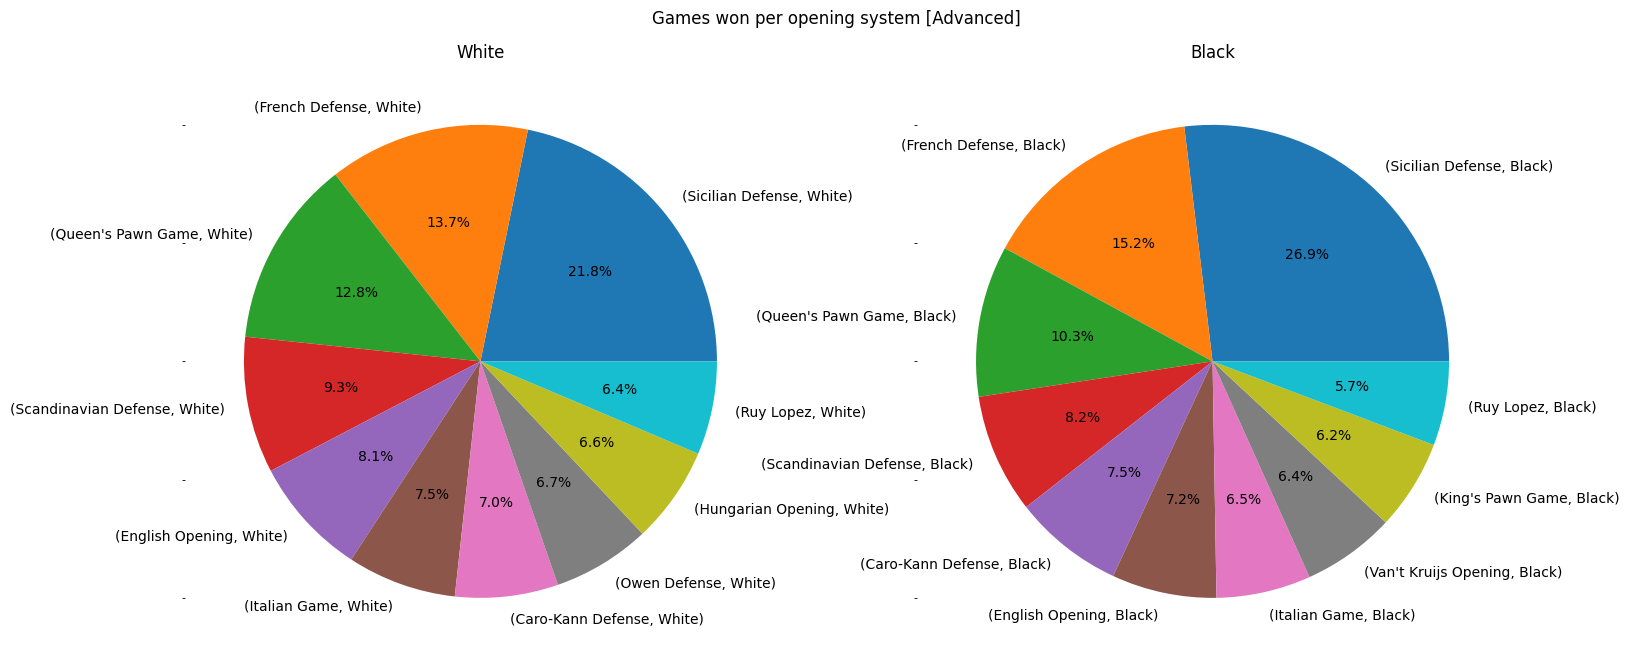

In [75]:
two_pie_chart(advanced_stats_white, 'White', advanced_stats_black,'Black', 'Games won per opening system [Advanced]')

In [76]:
expert_stats_white = game_stats(df[expert_white], "White")
expert_stats_black = game_stats(df[expert_black], "Black")
expert_stats_white.nlargest(10), expert_stats_black.nlargest(10)

(opening_base             winner
 Sicilian Defense         White     277
 French Defense           White     178
 Queen's Pawn Game        White     136
 Caro-Kann Defense        White     129
 English Opening          White     120
 Zukertort Opening        White      91
 King's Indian Attack     White      88
 Queen's Gambit Declined  White      88
 Scandinavian Defense     White      88
 Queen's Gambit Refused   White      85
 Name: count, dtype: int64,
 opening_base             winner
 Sicilian Defense         Black     525
 French Defense           Black     199
 Caro-Kann Defense        Black     160
 English Opening          Black     120
 Queen's Pawn Game        Black     115
 Modern Defense           Black      90
 Owen Defense             Black      88
 Queen's Gambit Declined  Black      83
 Pirc Defense #4          Black      67
 Van't Kruijs Opening     Black      51
 Name: count, dtype: int64)

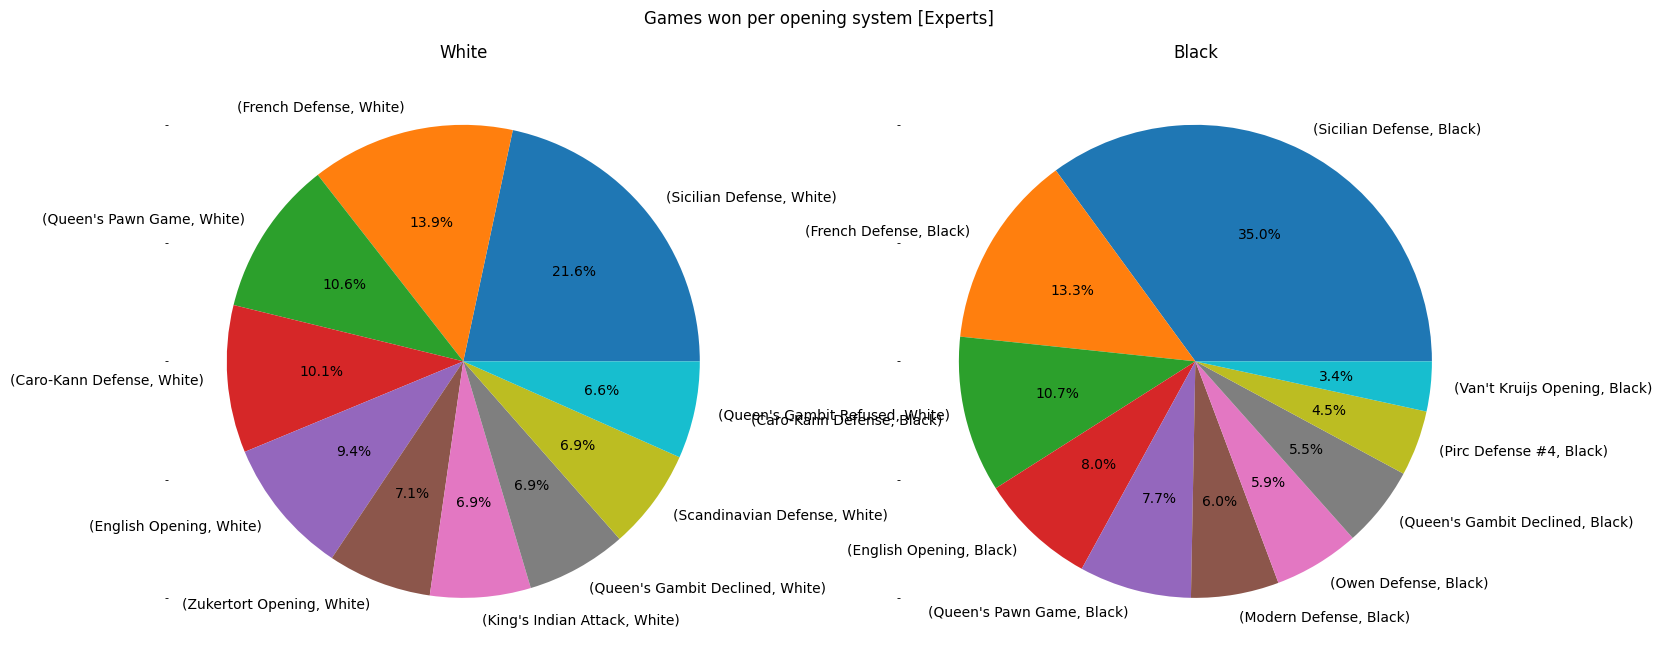

In [77]:
two_pie_chart(expert_stats_white, 'White', expert_stats_black, 'Black', 'Games won per opening system [Experts]')

## Results

### Question 1: What are the most frequently used opening systems?

We see the expected mix of are and complex opening systems for White which is due to the fact that the analysis was perfromed across all games independent of the players skill levels.  

The first three ranks contain complex systems with many variants that are probably used by more experienced players.
The King Pawn Game ob ranks is a special case sice it is both a system that beginners learn first as well as a system that is used by many experienced players. Rank 5 and 6 are examples of rare openings probably used by beginners.

### Question 2: Do we see a change in the most frequently used opening systems if we break the data by skill level?
Yes, we do. The change is as expected. In the beginners level, the Kings Pawn Game dominates. In addition, we ses rare and aggrassive openings sich as Scandinavian, Van't Kruijs, Hungarian and Kadas. These openings aim to outsmart the opponent quickly or luriing him in a trap, and can thus hardly be seen on tournament level. As we move on to intermediate players, the Sicilian Defense begins to dominate and keep doing so in the higher layers. The King's Pawn Game is on a declin. Intemediate players apparently pick more sophisticated openings and we can see the rise of the Queen's Pawn Game and the French Defense. In the intermediate level this exolution continues. The King Pawn Game has completely disappeared from the top-10 list and common openings such as Sicilian, French, Queen's Pawn Game or the Caro-Cann system can be seen. In the top-10 list of openings on expert level, Sicilean advances its lead to more than 33%, leading by far over French with 15%. English and the Caro-Cann system got stronger and the Queen's Gambit Declined shows up.  

### What are the most sucessfull opening systems for White or Black per skill level?

In the beginners_level, for both Black and White. Kings Pawn Game or Van't Kruijs seem to be the recommended choice since White won in more than 20% and 17% of all cases, respectively, which is better than for any other opening. At Intermediate level, the ranking up to rank 4 is the same for Black and White with Sicilian Defense, King's Pawn Game,
French Defense, and Queen's Pawn Game being the most promising choices. At advanced level, Kings Pawn is not successful anymore for White while Sicilian, French, and Queen's Pawn keep their string positions. Sicilian is very successfull for Black. For expert level players, Sicilian seems to be the opening base of choice both for White and Black. White won in 21% of all cases, clearly ahead of French. For Black the numbers are very clear Black won with Sicilian in 35% or all cases, almost three time as often as with the runner-up French again. 